In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocessing(text):
    
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')
    word_to_id = {}
    id_to_word = {}
    
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
        
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [18]:
def create_to_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [19]:
def cos_similarity(x, y, eps=1e-8):
    
    # 분모 0이 되지않게 하기 위해서 epsilon을 더해준다
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    
    return np.dot(nx, ny)

In [20]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    
  # 1.검색어를 꺼낸다.
    if query not in word_to_id:
        print('%s(을)를 찾을 수 없습니다.' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
  

  # 2. 코사인 유사도 계산
    vocab_size = len(id_to_word)

    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
        
  # 3. 코사인 유사도를 기준으로 내림차순으로 출력
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [21]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j]*N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% 완료' %(100*cnt/total))
                    
    return M

In [22]:
text = 'You say goodbye and I say hello'
corpus, word_to_id, id_to_word = preprocessing(text)

vocab_size = len(id_to_word)
C = create_to_matrix(corpus, vocab_size, window_size=1)

#most_similar('you', word_to_id, id_to_word, C)

In [23]:
C

array([[0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [0, 1, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [24]:
W = ppmi(C)
print(W)

[[0.        1.5849625 0.        0.        0.        0.       ]
 [1.5849625 0.        0.5849625 0.        0.5849625 1.5849625]
 [0.        0.5849625 0.        1.5849625 0.        0.       ]
 [0.        0.        1.5849625 0.        1.5849625 0.       ]
 [0.        0.5849625 0.        1.5849625 0.        0.       ]
 [0.        1.5849625 0.        0.        0.        0.       ]]


In [25]:
U, S, V = np.linalg.svd(W)
print("---U---")
print(U)
print("---S---")
print(S)
print("---V---")
print(V)

---U---
[[-4.5236292e-01  0.0000000e+00  0.0000000e+00 -5.4347748e-01
   1.8343325e-01 -6.8289989e-01]
 [ 5.5511151e-17 -7.6859325e-01  6.3973778e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.4347748e-01  2.2194280e-17  5.5553814e-17  4.5236292e-01
   6.8289989e-01  1.8343325e-01]
 [-1.1102230e-16 -6.3973778e-01 -7.6859325e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.4347748e-01  2.2194280e-17  5.5553814e-17  4.5236292e-01
  -6.8289989e-01 -1.8343325e-01]
 [-4.5236292e-01  1.3242758e-17  3.3147536e-17 -5.4347748e-01
  -1.8343325e-01  6.8289989e-01]]
---S---
[2.6929517e+00 2.6929517e+00 1.8656898e+00 1.8656898e+00 2.1982017e-17
 1.2378395e-35]
---V---
[[ 1.76952594e-17 -7.68593252e-01  8.46085246e-18 -6.39737785e-01
   8.46085246e-18  6.68263600e-17]
 [-4.52362925e-01  0.00000000e+00 -5.43477476e-01  0.00000000e+00
  -5.43477476e-01 -4.52362925e-01]
 [ 5.43477476e-01  1.94289029e-16 -4.52362925e-01  0.00000000e+00
  -4.52362925e-01  5.43477476e-01]
 [-4.02199119e-

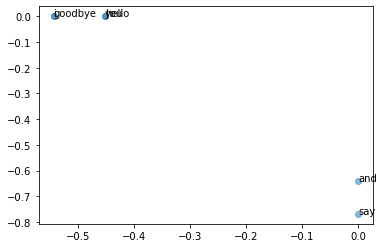

In [28]:
for word, word_id, in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()